In [1]:
# Imports
import numpy as np
import pandas as pd
import pickle
from pathlib import Path
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import Descriptors
import seaborn as sn
import dask
from dask.distributed import Client
import dask.bag as db

In [2]:
dtypes = {'buildingblock1_smiles': np.int16, 'buildingblock2_smiles': np.int16, 'buildingblock3_smiles': np.int16,
          'binds_BRD4':np.byte, 'binds_HSA':np.byte, 'binds_sEH':np.byte}

directory = Path("../data/shrunken/")
train = pd.read_parquet(directory / "train.parquet")

In [3]:
BBs_dict_reverse_1 = pickle.load(open(directory / 'train_dicts/BBs_dict_reverse_1.p', 'br'))
BBs_dict_reverse_2 = pickle.load(open(directory / 'train_dicts/BBs_dict_reverse_2.p', 'br'))
BBs_dict_reverse_3 = pickle.load(open(directory / 'train_dicts/BBs_dict_reverse_3.p', 'br'))

In [4]:
client = Client()

In [19]:
# Get 25 descriptors
desc_list = [desc_func for desc_name, desc_func in Descriptors._descList][:18]
desc_names = [desc_name for desc_name, desc_func in Descriptors._descList][:18]

def calculate_single_descriptor(mol, desc):
    return desc(mol)

# Create a function to calculate descriptors
def calculate_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    desc = [calculate_single_descriptor(mol, desc) for desc in desc_list]
    return desc


In [20]:
# Create train dataset with 25% binds_BRD4 or binds_HSA or binds_sEH and 75% no binds
train_df = train[(train.binds_BRD4 == 1) | (train.binds_HSA == 1) | (train.binds_sEH == 1)].sample(n=250000)
train_df = pd.concat([train_df, train[(train.binds_BRD4 == 0) & (train.binds_HSA == 0) & (train.binds_sEH == 0)].sample(n=750000)])
train_df.reset_index(drop=True, inplace=True)

In [21]:
b = db.from_sequence(train_df.molecule_smiles)
descriptors = b.map(calculate_descriptors)

In [22]:
descriptors = descriptors.compute()

/home/schobbejak/competitions/q4-detect-protein/venv/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 74.27 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [23]:
len(descriptors)

1000000

In [24]:
# Create a dataframe
desc_df = pd.DataFrame(descriptors, columns=desc_names)

# Add the target columns
desc_df['binds_BRD4'] = train_df.binds_BRD4
desc_df['binds_HSA'] = train_df.binds_HSA
desc_df['binds_sEH'] = train_df.binds_sEH

# Calculate correlation matrix
corr = desc_df.iloc[:, ].corr()

In [40]:
# Value counts
print(f"Count of binds_BRD4: {desc_df.binds_BRD4.value_counts()}")
print(f"Count of binds_HSA: {desc_df.binds_HSA.value_counts()}")
print(f"Count of binds_sEH: {desc_df.binds_sEH.value_counts()}")

Count of binds_BRD4: binds_BRD4
0    924587
1     75413
Name: count, dtype: int64
Count of binds_HSA: binds_HSA
0    932176
1     67824
Name: count, dtype: int64
Count of binds_sEH: binds_sEH
0    879876
1    120124
Name: count, dtype: int64


<Axes: >

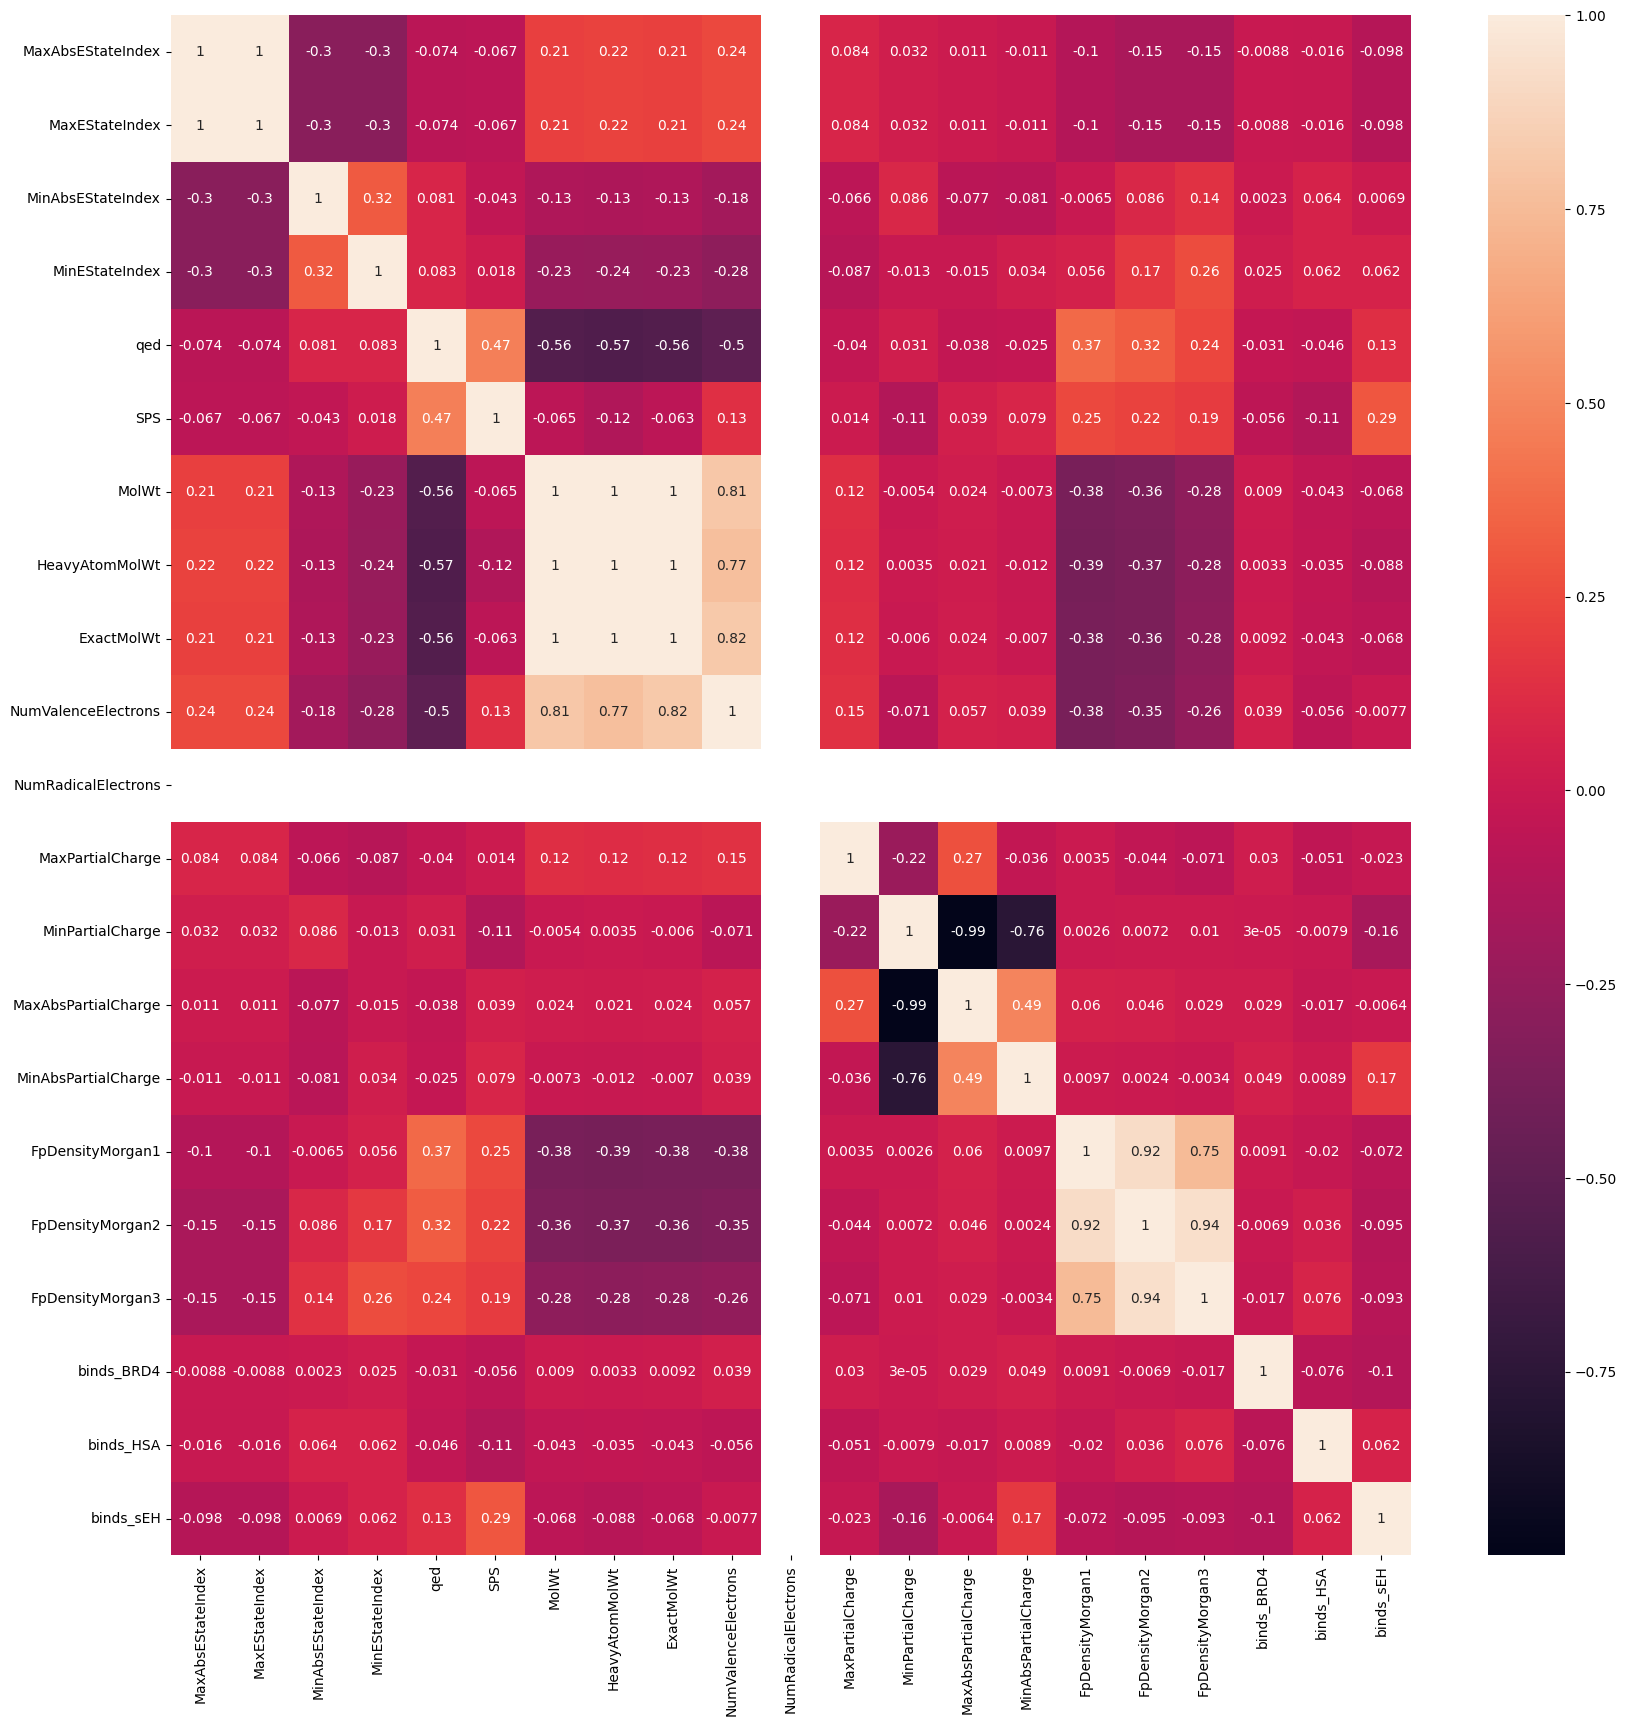

In [41]:
# Make the plot bigger
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 20))
sn.heatmap(corr, annot=True)

In [29]:
print(f"Percentage of rows with at least one binding: {desc_df[(desc_df.binds_BRD4 == 1) | (desc_df.binds_HSA == 1) | (desc_df.binds_sEH == 1)].shape[0] / desc_df.shape[0] * 100:.2f}%")

Percentage of rows with at least one binding: 25.00%


In [44]:
# Replace NaN values with 0
desc_df.fillna(0, inplace=True)

# Replace inf values with 0
desc_df.replace([np.inf, -np.inf], 0, inplace=True)

In [49]:
# Train XGBoost model to predict binds_BRD4, binds_sEH, binds_HSA
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

X = desc_df.iloc[:, :-3]
y = desc_df.iloc[:, -3:]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model = XGBClassifier()
model.fit(X, y)

# Get accuracy
from sklearn.metrics import average_precision_score
y_pred = model.predict(X_test)
accuracy = average_precision_score(y_test, y_pred, average='micro')
print(f"Accuracy: {accuracy}")

Accuracy: 0.35254530412446705


In [46]:
# Load test data
test = pd.read_parquet(directory / "test.parquet")

In [47]:
test.head(10)

,buildingblock1_smiles,buildingblock2_smiles,buildingblock3_smiles,molecule_smiles,is_BRD4,is_HSA,is_sEH
0,0,17,17,C#CCCC[C@H](Nc1nc(Nc2ccc(C=C)cc2)nc(Nc2ccc(C=C...,True,True,True
1,0,17,87,C#CCCC[C@H](Nc1nc(Nc2ccc(C=C)cc2)nc(Nc2ncnc3c2...,True,True,True
2,0,17,99,C#CCCC[C@H](Nc1nc(NCC2(O)CCCC2(C)C)nc(Nc2ccc(C...,True,True,True
3,0,17,244,C#CCCC[C@H](Nc1nc(Nc2ccc(C=C)cc2)nc(Nc2sc(Cl)c...,True,True,True
4,0,17,394,C#CCCC[C@H](Nc1nc(NCC2CCC(SC)CC2)nc(Nc2ccc(C=C...,True,True,True
5,0,17,499,C#CCCC[C@H](Nc1nc(NCc2ccc(C)cc2N2CCCC2)nc(Nc2c...,True,True,True
6,0,17,518,C#CCCC[C@H](Nc1nc(NCCc2ccc(OCC(=O)Nc3cccc(C)c3...,True,True,True
7,0,17,536,C#CCCC[C@H](Nc1nc(NCCCNC(=O)c2occc2C)nc(Nc2ccc...,True,True,True
8,0,17,651,C#CCCC[C@H](Nc1nc(NCc2nnc(N3CCCC3)o2)nc(Nc2ccc...,True,True,True
9,0,17,731,C#CCCC[C@H](Nc1nc(NCCc2csc3ccccc23)nc(Nc2ccc(C...,True,True,True


In [48]:
# Make predictions on test data

test_b = db.from_sequence(test.molecule_smiles)
test_descriptors = test_b.map(calculate_descriptors)
test_descriptors = test_descriptors.compute()


/home/schobbejak/competitions/q4-detect-protein/venv/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 65.63 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [50]:
# Fill NaN values with 0
test_desc_df = pd.DataFrame(test_descriptors, columns=desc_names)
test_desc_df.fillna(0, inplace=True)
test_desc_df.replace([np.inf, -np.inf], 0, inplace=True)

In [51]:
# Predict on test data
predictions = model.predict(test_desc_df)

In [52]:
# Create new dataframe with predictions
predictions_df = pd.DataFrame(predictions, columns=['binds_BRD4', 'binds_HSA', 'binds_sEH'])

In [53]:
# From test dataframe add is_BRD4, is_HSA, is_sEH columns
predictions_df['is_BRD4'] = test.is_BRD4
predictions_df['is_HSA'] = test.is_HSA
predictions_df['is_sEH'] = test.is_sEH

predictions_df.head(10)

,binds_BRD4,binds_HSA,binds_sEH,is_BRD4,is_HSA,is_sEH
0,0.0,0.0,0.0,True,True,True
1,0.0,0.0,0.0,True,True,True
2,0.0,0.0,0.0,True,True,True
3,0.0,0.0,0.0,True,True,True
4,0.0,0.0,0.0,True,True,True
5,0.0,0.0,0.0,True,True,True
6,0.0,0.0,0.0,True,True,True
7,0.0,0.0,0.0,True,True,True
8,0.0,0.0,0.0,True,True,True
9,0.0,0.0,0.0,True,True,True


In [54]:
# Map predictions to ids from test data
original_test = pd.read_parquet("../data/raw/test.parquet")

# Predictions are (binds_BRD4, binds_HSA, binds_sEH) these should be mapped to the original ids
# If you have id_1, id_2, id_3, id_4, id_5, id_6
# And you have predictions (1, 0, 1), (0,1,0)
# You should map these to id_1, id_3, id_5

# Get the original ids
original_ids = original_test.id

# Create a flattened array of predictions where each row is only given if its corresponding is_ is true
# For example if is_BRD4 is true, then the prediction is binds_BRD4 else it is skipped and shouldn't be included in the final array
final_predictions = []
for i in range(predictions_df.shape[0]):
    if predictions_df.iloc[i].is_BRD4:
        final_predictions.append(predictions_df.iloc[i].binds_BRD4)
    if predictions_df.iloc[i].is_HSA:
        final_predictions.append(predictions_df.iloc[i].binds_HSA)
    if predictions_df.iloc[i].is_sEH:
        final_predictions.append(predictions_df.iloc[i].binds_sEH)

In [61]:
# For final predictions, if its 1 choose random value from 0.5 to 1, if its 0 choose random value from 0 to 0.5
new_final_predictions = [np.random.uniform(0.5, 1) if pred == 1 else np.random.uniform(0, 0.5) for pred in final_predictions]

In [62]:
# Create a dataframe with the final predictions columns are id and binds
final_predictions_df = pd.DataFrame({'id': original_ids, 'binds': new_final_predictions})

In [63]:
# Check if any predictions are 1
print(f"Number of binds: {final_predictions_df[final_predictions_df.binds == 1].shape[0]}")

Number of binds: 0


In [64]:
final_predictions_df.shape

(1674896, 2)

In [65]:
# Save the final predictions as csv
final_predictions_df.to_csv("../data/predictions.csv", index=False)